# **PRiAD - projekt**

### Skład zepsołu:
* Daria Danieluk
* Kateryna Kononova
* Weronika Zbierowska

## Cel projektu


Projekt polega na wykonaniu analizy zbioru danych CIC-Darnket2020 zawierającego dane o ruchu sieciowym. Celem jest przeprowadzenie 2 rodzajów klasyfikacji: binarnej TOR vs NonTOR oraz klasyfikacji ruchu według rodzaju usługi.



**CIC-Darnket2020**

Zbiór danych który pozwala na wykrywanie i chrakteryzwoanie razem aplikacji VPN i Tor jako przedstawiciela ruchu w Darknecie poprzez połączenie dwóch zbiorów ISCXTor2016 i ISCXVPN2016. Nasz projekt skupi się na analizie części zbioru poświęconej ruchowi Tor vs Non-Tor.

**TCP**

Protkół TCP jest protokołem transportowym używanym jako dodatek do protokołu IP w celu zapewnienia wiarygodnej transmisji pakietów. TCP zawiera mecheniazmy umożliwiające rozwiązanie problemów związanych z przesyłaniem pakietów: zgubione, uszkodzone, zduplikowane pakiety. Ponieważ protokół TCP jest najczęsciej użuywany jako dodatek do protokołu IP, często określamy go jako TCP/IP.

**Format pakietu TCP**

Kiedy przesyłamy dane przez TCP/IP, każda porcja danych jest formatowana do segmentu TCP. Każdy segemnt TCP zawiera nagłówek (header) i dane.
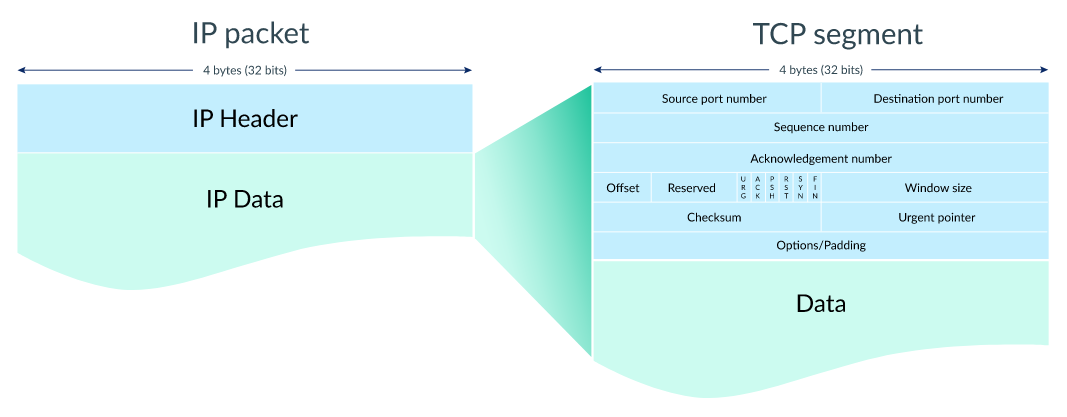
*Źródło: https://www.khanacademy.org/computing/computers-and-internet/xcae6f4a7ff015e7d:the-internet/xcae6f4a7ff015e7d:transporting-packets/a/transmission-control-protocol--tcp*

**Flagi TCP**  
Każdy nagłówek TCP zawiera kilka 1-bitowych pól nazwanych flagami, które warunkują przepływ danych przez połączenie TCP:
* SYN - inicjalizuje połączenie
* ACK - potwierdza odebranie dane
* FIN - zamyka połączenie
* RST - przerywa połączenie, gdy pojawia się błąd
* PSH (push)
* URG (urgent)

**Flaga PSH**

Protokół TCP działa na czwartej warstwie (warstwa transportowa) modelu OSI, aby umożliwić aplikacjom odczyt i zapis. Implementowane są bufory po obu stronach połączenia. Pozwalają one na bardziej wydajny transfer danych, wtedy przesyłamy więcej niż jeden maksymalny segment danych. Jednak jeśli chcemy przesłać dane od razu, bez czekania aż bufor się wypełni, należy ustawić flagę PSH na '1'. Flaga PSH zapewnia nas, że:
* aplikacja, która wysyła dane, informuje TCP, że dane powinny zostać wysłane natychmiastowo
* flaga PSH w nagłówku informuje odbierającego host'a, że dane powinny zostać wysłane do odbierającej aplikacji natychmiastowo

**Flaga URG**

Flaga URG służy do informowania stacji odbierającej, że konkretne dane w segmencie są pilne i powinny być priorytetowe. Jeżeli flaga URG jest ustawiona, stacja odbierająca ustawia urgent pointer (wskaźnik pilności), czyli 16-bitowe pole w nagłówku TCP. Urgent pointer wskazuje, jaka część danych w segmencie, licząc od pierwszego bajtu, jest pilna.


**TOR vs Non-TOR**

TOR jest przeglądarką przeznaczoną do anonimowego przeglądania sieci, zabezpiecza przed analizą ruchu. TOR używa technologii zwanej onion routing (trasowanie cebulowe), która używa komunikacji P2P. Trasownik cebulowy używa wielu warstw szyfrowania, aby ukryć pierwotne źródło i miejsce docelowe, gdzie są przesyłane informacje. Został zaprojektowany w taki sposób, aby nikt nie mógł monitorować, ani cenzurować komunikacji.

## Opis zbioru danych

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.2f}".format 

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn import tree

In [2]:
# wczytanie i dopasowanie danych do wymagań projektowych
cols_list = ['Total Length of Fwd Packet', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Packet Length Min', 'Packet Length Max', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'Label', 'Label.1']
df = pd.read_csv('Darknet.CSV', usecols=cols_list) # ewentualnie ignorować błędy
df = df.loc[(df['Label'] == 'Tor') | (df['Label'] == 'Non-Tor')]
df.loc[df['Label.1'] == 'AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
df.loc[df['Label.1'] == 'File-transfer', 'Label.1'] = 'File-Transfer'
df.rename(columns={'Label': 'Network Category', 'Label.1': 'Traffic Category'}, inplace=True)
df.head()

,Total Length of Fwd Packet,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count,Network Category,Traffic Category
0,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
1,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
2,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
3,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
4,64530,1,0,0,0,11820,8000,0,498,1,0,0,Non-Tor,Audio-Streaming


In [3]:
print("Liczba wierszy = ", df.shape[0])
print("Liczba kolumn = ", df.shape[1])
df.info()

Liczba wierszy =  94748
Liczba kolumn =  14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Total Length of Fwd Packet  94748 non-null  int64 
 1   Fwd PSH Flags               94748 non-null  int64 
 2   Bwd PSH Flags               94748 non-null  int64 
 3   Fwd URG Flags               94748 non-null  int64 
 4   Bwd URG Flags               94748 non-null  int64 
 5   Fwd Header Length           94748 non-null  int64 
 6   Bwd Header Length           94748 non-null  int64 
 7   Packet Length Min           94748 non-null  int64 
 8   Packet Length Max           94748 non-null  int64 
 9   FIN Flag Count              94748 non-null  int64 
 10  SYN Flag Count              94748 non-null  int64 
 11  RST Flag Count              94748 non-null  int64 
 12  Network Category            94748 non-null  object
 13  T

Wybrana część zbioru danych CIC-Darknet2020 składa się z 94748 wierszy i 14 kolumn - 12 atrybutów opisujących i 2 atrybutów decyzyjnych.

Atrybuty opisujące w zbiorze:
1. **Total Length of Fwd Packet** - łączna długość pakietów wysłanych do przodu
2. **Fwd PSH Flags** - liczba flag PUSH ustawionych w pakietach przesyłanych do przodu
3. **Bwd PSH Flags** - liczba flag PUSH ustawionych w pakietach przesyłanych do tyłu
4. **Fwd URG Flags** - liczba flag URGENT ustawionych w pakietach przesyłanych do przodu
5. **Bwd URG Flags** - liczba flag URGENT ustawionych w pakietach przesyłanych do tyłu
6. **Fwd Header Length** - długość nagłówka przesyłanego do przodu
7. **Bwd Header Length** - długość nagłówka przesyłanego do tyłu
8. **Packet Length Min** - minimalna długość pakietu wysłanego w dowolnym kierunku
9. **Packet Length Max** - maksymalna długość pakietu wysłanego w dowolnym kierunku
10. **FIN Flag Count** - liczba flag FINISH
11. **SYN Flag Count** - liczba flag SYN
12. **RST Flag Count** - liczba flag RST

Fwd = Forward (w przód)  
Bwd = Backward (w tył)

## Analiza ekploracyjna danych

### Braki w danych

In [4]:
print("Liczba brakujących danych = ", df.isnull().sum().sum())

Liczba brakujących danych =  0


W zbiorze nie występują żadne braki w danych.

### Podstawowe statystyki na temat atrybutów opisujących w zbiorze

In [5]:
df.describe()

,Total Length of Fwd Packet,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,9.474800e+04,94748.000000,94748.0,94748.0,94748.0,9.474800e+04,9.474800e+04,94748.000000,94748.000000,94748.000000,94748.000000,94748.000000
mean,1.285454e+05,0.120762,0.0,0.0,0.0,2.954200e+03,2.605246e+03,7.753947,333.975208,0.604783,0.627443,0.027367
std,2.305133e+06,0.325853,0.0,0.0,0.0,3.820125e+04,3.005228e+04,17.224699,580.153254,0.566279,0.928077,0.212689
min,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.0,0.0,0.0,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+01,0.000000,0.0,0.0,0.0,4.000000e+01,2.000000e+01,0.000000,52.000000,1.000000,0.000000,0.000000
75%,4.460000e+02,0.000000,0.0,0.0,0.0,1.120000e+02,9.200000e+01,0.000000,407.250000,1.000000,2.000000,0.000000
max,1.434918e+08,1.000000,0.0,0.0,0.0,2.279200e+06,1.632600e+06,1350.000000,33450.000000,2.000000,3.000000,16.000000


Zakresy wartości poszczególnych atrybutów:
* wartości atrybutu `Total Length of Fwd Packet` zmieniają się w bardzo dużym zakresie, od 0 do rzędu wielkości 10^8
* wartości atrybutów `Fwd Header Length` oraz `Bwd Header Length` zmieniają się w bardzo dużym zakresie, od 0 do rzędu wielkości 10^6
* wartości atrybutu `Packet Length Min` zmieniają się w dużym zakresie, od 0 do rzędu wielkości 10^3
* wartości atrybutu `Packet Length Max` zmieniają się w dużym zakresie, od 0 do rzędu wielkości 10^4
* wartości atrybutów `Bwd PSH Flags`, `Fwd URG Flags` oraz `Bwd URG Flags` są równe 0 dla wszystkich obiektów
* wartości atrybutu `Fwd PSH Flags` przyjmują wartości 0 lub 1
* wartości atrybutu `FIN Flag Count` przyjmują wartości 0, 1 lub 2
* wartości atrybutu `SYN Flag Count` przyjmują wartości 0, 1, 2 lub 3
* wartości atrybutu `RST Flag Count` zmieniają się w zakresie <0, 16>  
  
Jak można zauważyć, w zbiorze danych występują atrybuty o różnych zakresach zmienności, są niewspółmierne. Ich dokładny rozkład zostanie poddany analizie w dalszej części. Atrybuty `Bwd PSH Flags`, `Fwd URG Flags` oraz `Bwd URG Flags` zostaną wykluczone z dalszej analizy - nic do niej nie wnoszą.

In [3]:
df.drop(columns=['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Total Length of Fwd Packet  94748 non-null  int64 
 1   Fwd PSH Flags               94748 non-null  int64 
 2   Fwd Header Length           94748 non-null  int64 
 3   Bwd Header Length           94748 non-null  int64 
 4   Packet Length Min           94748 non-null  int64 
 5   Packet Length Max           94748 non-null  int64 
 6   FIN Flag Count              94748 non-null  int64 
 7   SYN Flag Count              94748 non-null  int64 
 8   RST Flag Count              94748 non-null  int64 
 9   Network Category            94748 non-null  object
 10  Traffic Category            94748 non-null  object
dtypes: int64(9), object(2)
memory usage: 8.7+ MB


### Podstawowe statystyki na temat atrybutów opisujących - porównanie Tor vs Non-Tor

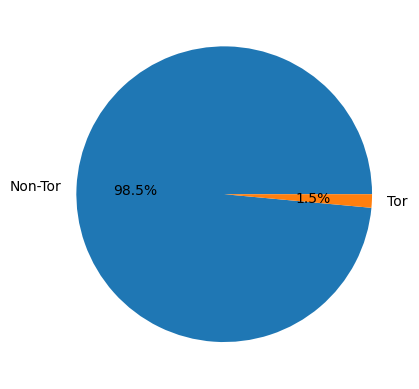

In [7]:
labels = ['Non-Tor', 'Tor']
sizes = [df[df['Network Category'] == 'Non-Tor'].shape[0], df[df['Network Category'] == 'Tor'].shape[0]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

Zbiór danych jest niezbalansowany - obiektów klasy `Non-Tor` jest znacznie więcej niż obiektów klasy `Tor`.

In [8]:
print("Liczba obiektów w klasie Non-Tor = ", df[df['Network Category'] == 'Non-Tor'].shape[0])
df[df['Network Category'] == 'Non-Tor'].describe()

Liczba obiektów w klasie Non-Tor =  93356


,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,9.335600e+04,93356.000000,9.335600e+04,9.335600e+04,93356.000000,93356.000000,93356.000000,93356.000000,93356.000000
mean,3.714035e+04,0.113126,1.117060e+03,1.256511e+03,7.828174,319.667981,0.612183,0.635546,0.027561
std,1.087435e+06,0.316749,1.670923e+04,1.924600e+04,17.217206,527.000946,0.565198,0.931203,0.213017
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+01,0.000000,4.000000e+01,2.000000e+01,0.000000,52.000000,1.000000,0.000000,0.000000
75%,4.090000e+02,0.000000,1.120000e+02,9.200000e+01,0.000000,328.000000,1.000000,2.000000,0.000000
max,8.014597e+07,1.000000,1.110420e+06,1.077432e+06,1350.000000,1460.000000,2.000000,2.000000,16.000000


In [9]:
print("Liczba obiektów w klasie Tor = ", df[df['Network Category'] == 'Tor'].shape[0])
df[df['Network Category'] == 'Tor'].describe()

Liczba obiektów w klasie Tor =  1392


,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,1.392000e+03,1392.000000,1.392000e+03,1.392000e+03,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000
mean,6.258728e+06,0.632902,1.261640e+05,9.305965e+04,2.775862,1293.505029,0.108477,0.084052,0.014368
std,1.563346e+07,0.482187,2.554321e+05,1.683665e+05,17.001629,1830.630880,0.390966,0.414654,0.189047
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.086000e+03,0.000000,9.600000e+01,9.600000e+01,0.000000,543.000000,0.000000,0.000000,0.000000
50%,1.034085e+05,1.000000,1.629000e+04,3.932000e+04,0.000000,1460.000000,0.000000,0.000000,0.000000
75%,1.705210e+06,1.000000,1.095050e+05,9.442500e+04,0.000000,1460.000000,0.000000,0.000000,0.000000
max,1.434918e+08,1.000000,2.279200e+06,1.632600e+06,191.000000,33450.000000,2.000000,3.000000,3.000000


Obserwując jedynie zakresy wartości poszczególnych atrybutów opisujących można wyciągnąć następujące wnioski:
* obiekty o wartości atrybutu `Total Length of Fwd Packet` > 8.014597e+07 występują jedynie w klasie `Tor`
* atrybuty `Fwd PSH Flags` oraz `FIN Flag Count` nie umożliwiają odróżnienia obiektów klasy `Tor` od obiektów klasy `Non-Tor`
* obiekty o wartości atrybutu `Fwd Header Length` > 1.110420e+06 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `Bwd Header Length` > 1.077432e+06 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `Packet Length Min` > 191 występują jedynie w klasie `Non-Tor`
* obiekty o wartości atrybutu `Packet Length Max` > 1460 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `SYN Flag Count` > 2 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `RST Flag Count` > 3 występują jedynie w klasie `Non-Tor`

### Analiza kategorii ruchu

In [10]:
print("Liczba kategorii ruchu = ", len(df.loc[:, 'Traffic Category'].unique()))

Liczba kategorii ruchu =  8


In [11]:
print("Liczba obiektów w danej klasie:")
for k in list(df.loc[:, 'Traffic Category'].unique()):
    print(k, " = ", df[df['Traffic Category'] == k].shape[0])

Liczba obiektów w danej klasie:
Audio-Streaming  =  1708
Browsing  =  32808
Chat  =  478
Email  =  505
File-Transfer  =  6847
P2P  =  48520
Video-Streaming  =  3584
VOIP  =  298


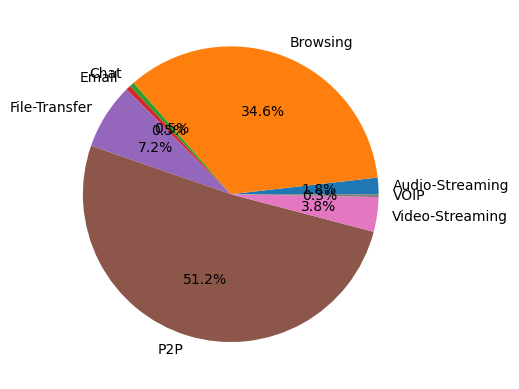

In [12]:
labels = []
sizes = []

for k in list(df.loc[:, 'Traffic Category'].unique()):
    labels.append(k)
    sizes.append(df[df['Traffic Category'] == k].shape[0])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

Liczba obiektów w poszczególnych kategoriach ruchu nie jest równa. Ponad połowa obiektów należy do kategorii `P2P`, a ponad 1/3 do kategorii `Browsing`. Jedynie 15% obiektów należy do pozostałych 6 kategorii.

In [86]:
# porównanie częstości występowania flag dla różnych kategorii ruchu
df_flags_traffic = df[['Fwd PSH Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count']].astype(bool)
df_flags_traffic['Traffic Category'] = df['Traffic Category']
df_flags_traffic.groupby('Traffic Category').mean()

,Fwd PSH Flags,FIN Flag Count,SYN Flag Count,RST Flag Count
Traffic Category,,,,
Audio-Streaming,0.28,0.29,0.14,0.01
Browsing,0.05,0.60,0.31,0.02
Chat,0.21,0.40,0.18,0.01
Email,0.15,0.46,0.24,0.07
File-Transfer,0.03,0.60,0.43,0.12
P2P,0.17,0.56,0.31,0.00
VOIP,0.65,0.14,0.05,0.02
Video-Streaming,0.12,0.44,0.22,0.06


In [87]:
# porównanie częstości występowania flag dla Tor vs Non-Tor
df_flags_network = df[['Fwd PSH Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count']].astype(bool)
df_flags_network['Network Category'] = df['Network Category']
df_flags_network.groupby('Network Category').mean()

,Fwd PSH Flags,FIN Flag Count,SYN Flag Count,RST Flag Count
Network Category,,,,
Non-Tor,0.11,0.57,0.32,0.02
Tor,0.63,0.08,0.04,0.01


### Rozkład wartości atrybutów opisujących w zbiorze danych

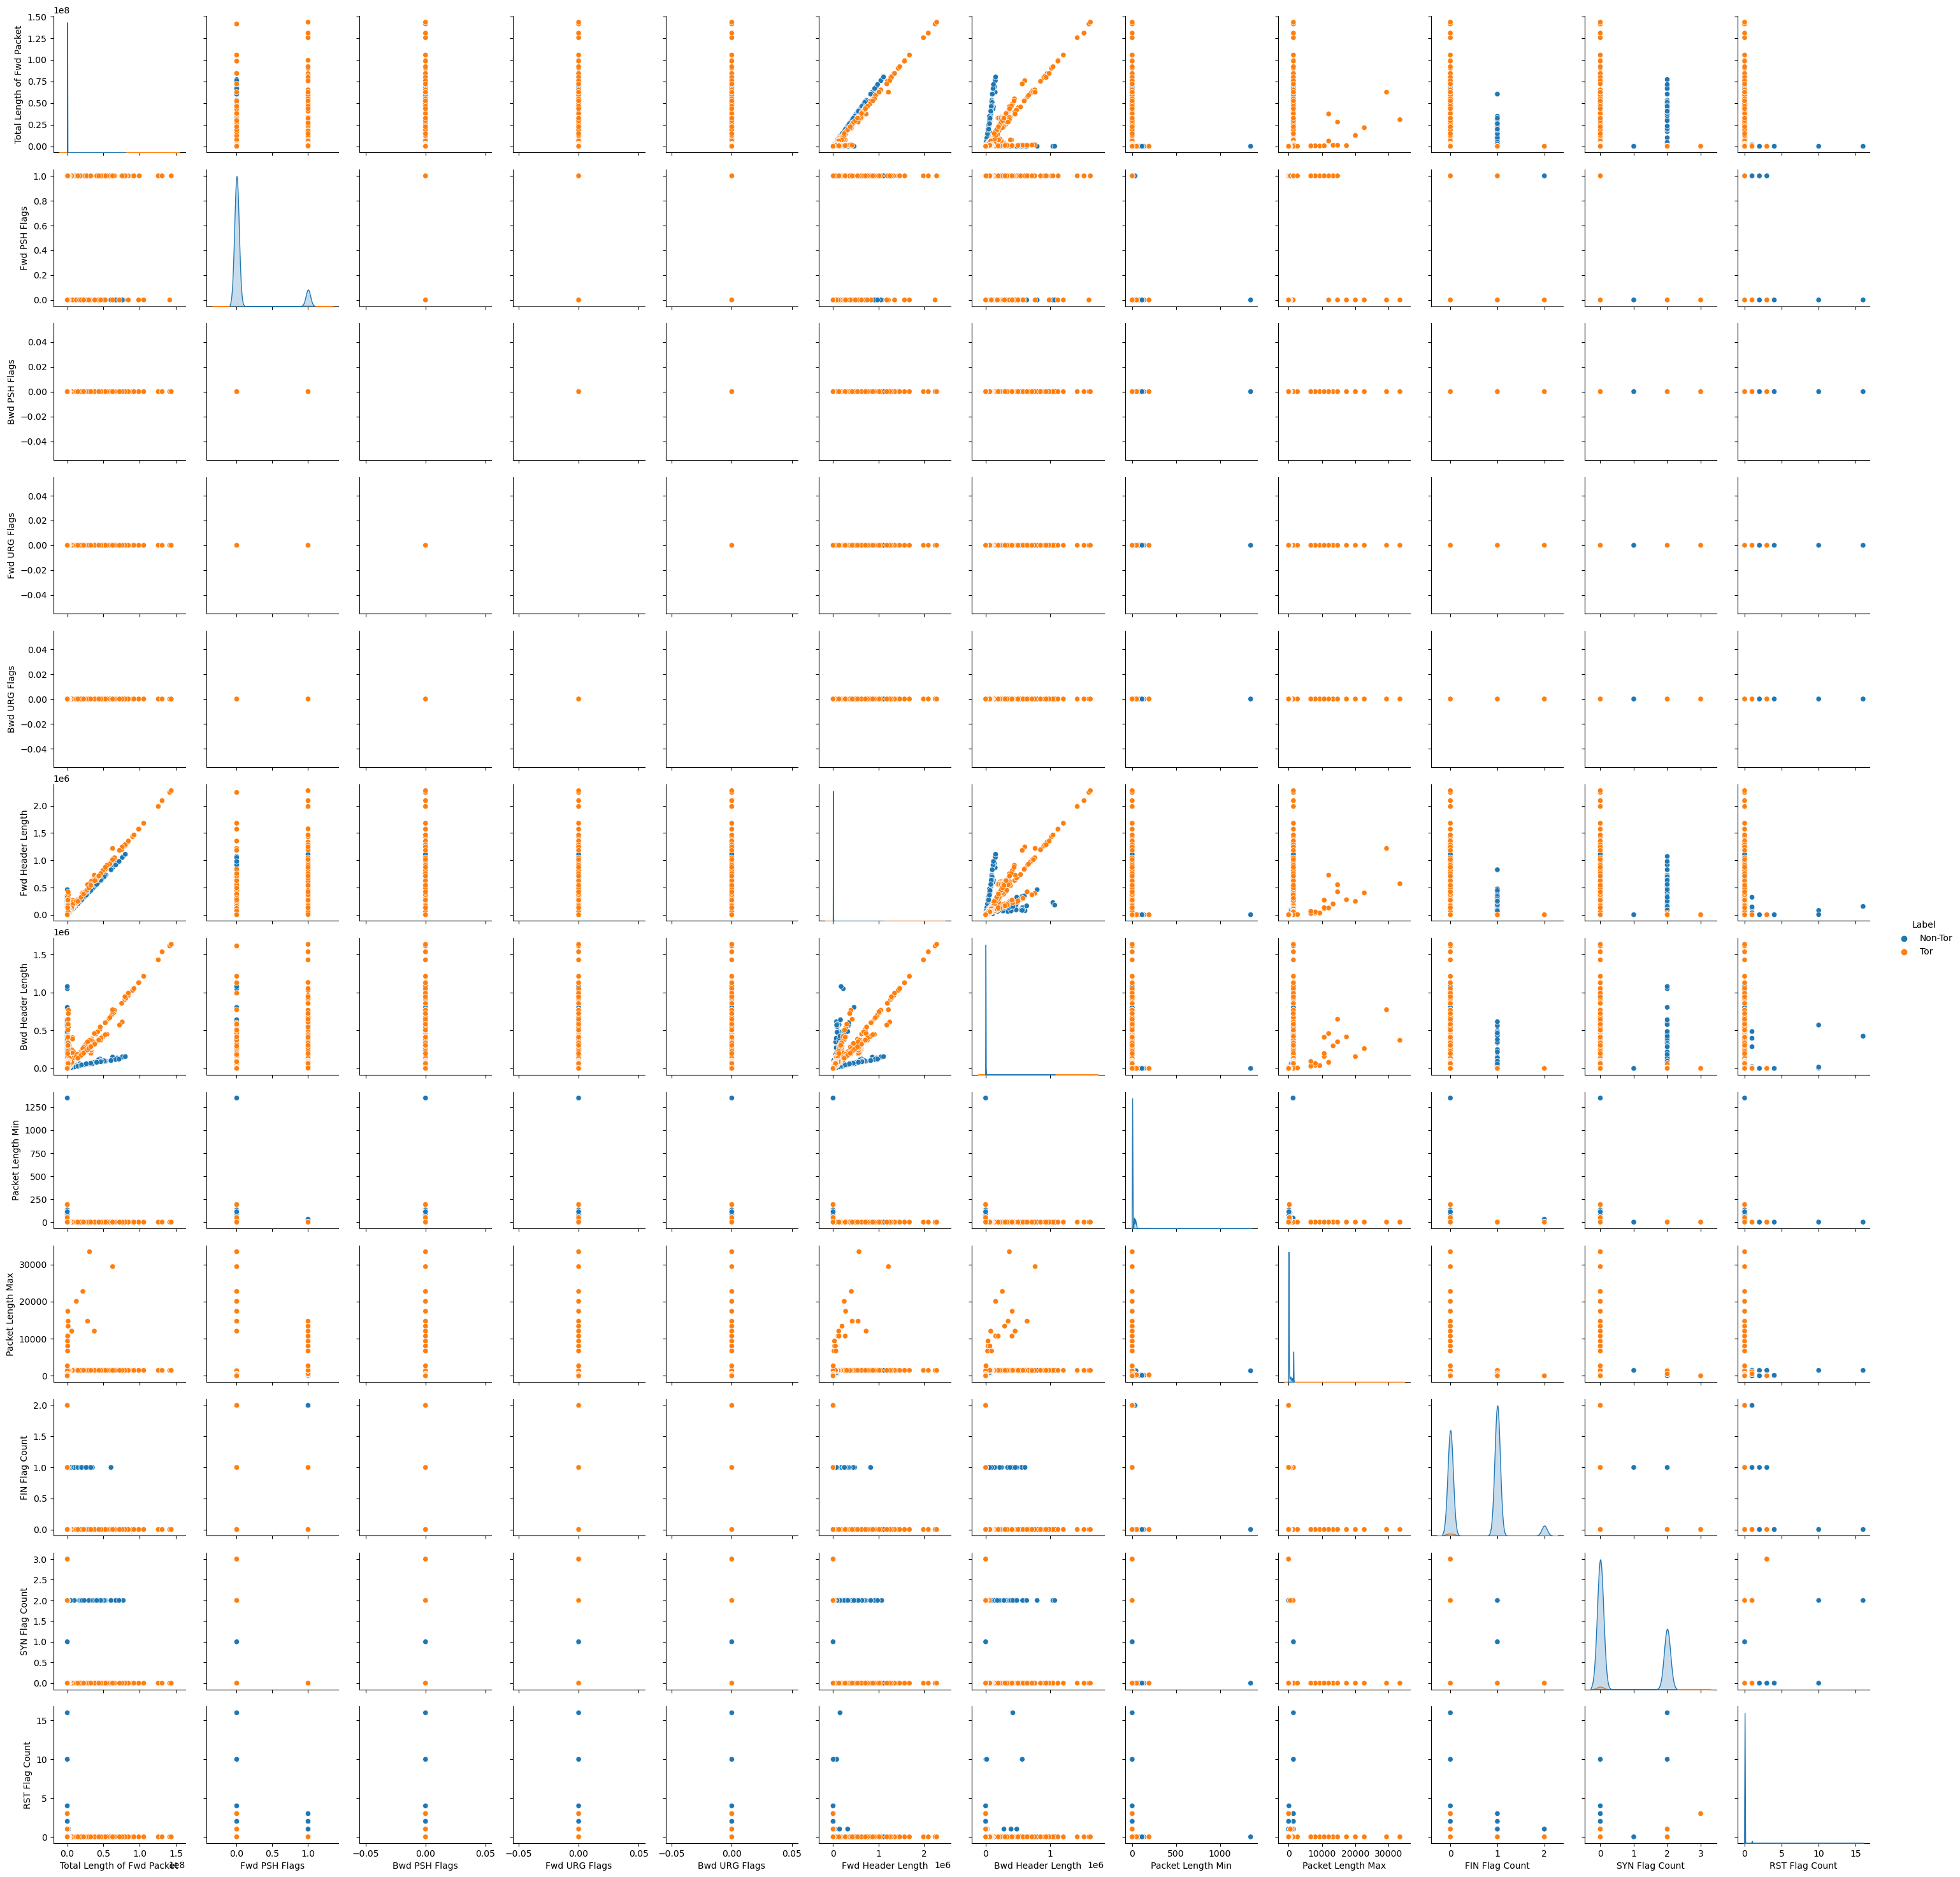

In [20]:
# NIE RUSZAĆ TEGO BLOKU, BO WYGENEROWANIE TEGO ZAJĘŁO BARDZO DUŻO CZASU I RAMU!!!
sns.pairplot(df, kind="scatter", hue="Network Category")
plt.show()

D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


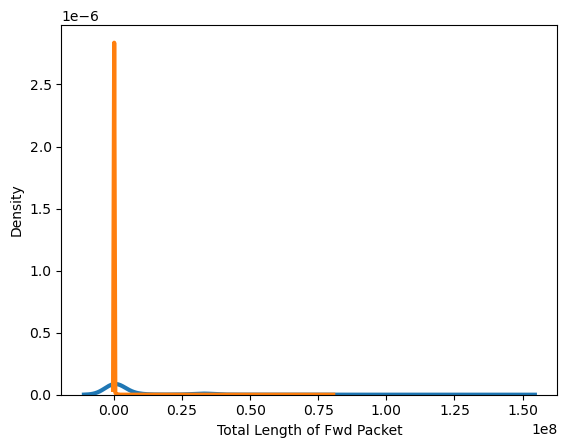

In [16]:
# DO USUNIĘCIA?
atr = 'Total Length of Fwd Packet'
network_categories = ['Tor', 'Non-Tor']

for k in network_categories:
    subset = df[df['Network Category'] == k]

    sns.distplot(subset[atr], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = k)
    
# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
#plt.title('Density Plot with Multiple Airlines')
#plt.xlabel('Delay (min)')
#plt.ylabel('Density')

D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total Length of Fwd Packet', ylabel='Density'>

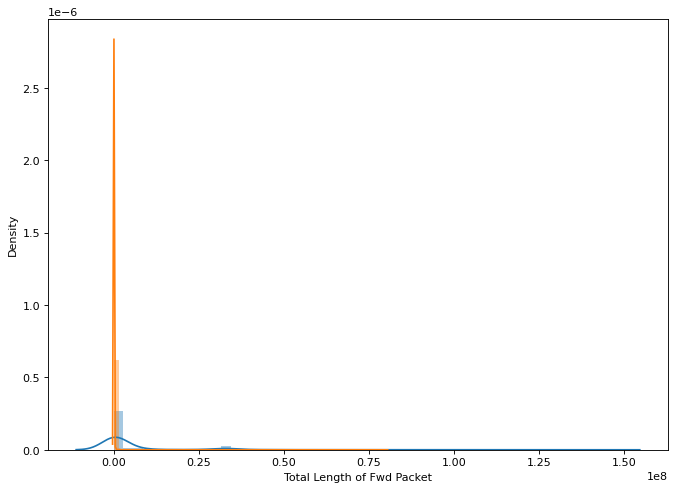

In [37]:
# DO USUNIĘCIA?
atr = 'Total Length of Fwd Packet'
plt.figure(figsize=(10, 7), dpi=80)
sns.distplot(df.loc[df['Network Category'] == 'Tor', atr], label="Tor")
sns.distplot(df.loc[df['Network Category'] == 'Non-Tor', atr], label="Non-Tor")

<AxesSubplot:ylabel='Frequency'>

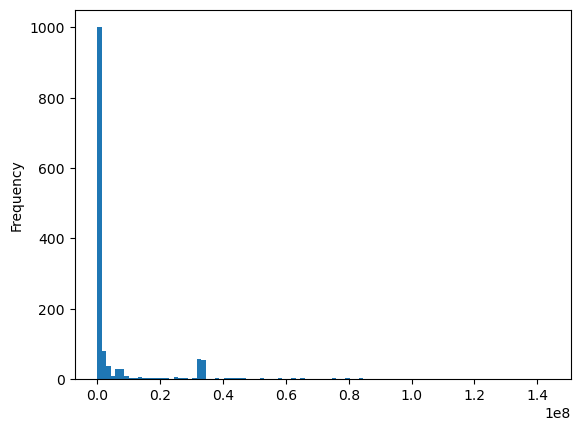

In [17]:
# DO USUNIĘCIA?
df_tor = df[df['Network Category'] == 'Tor']
df_tor['Total Length of Fwd Packet'].plot.hist(bins=100)

<AxesSubplot:>

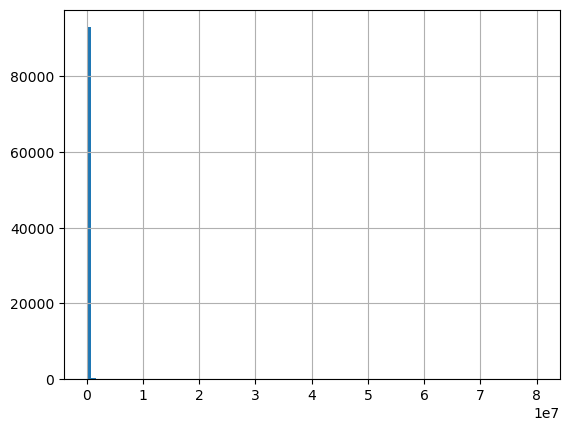

In [18]:
df_nontor = df[df['Network Category'] == 'Non-Tor']
df_nontor['Total Length of Fwd Packet'].hist(bins=100)

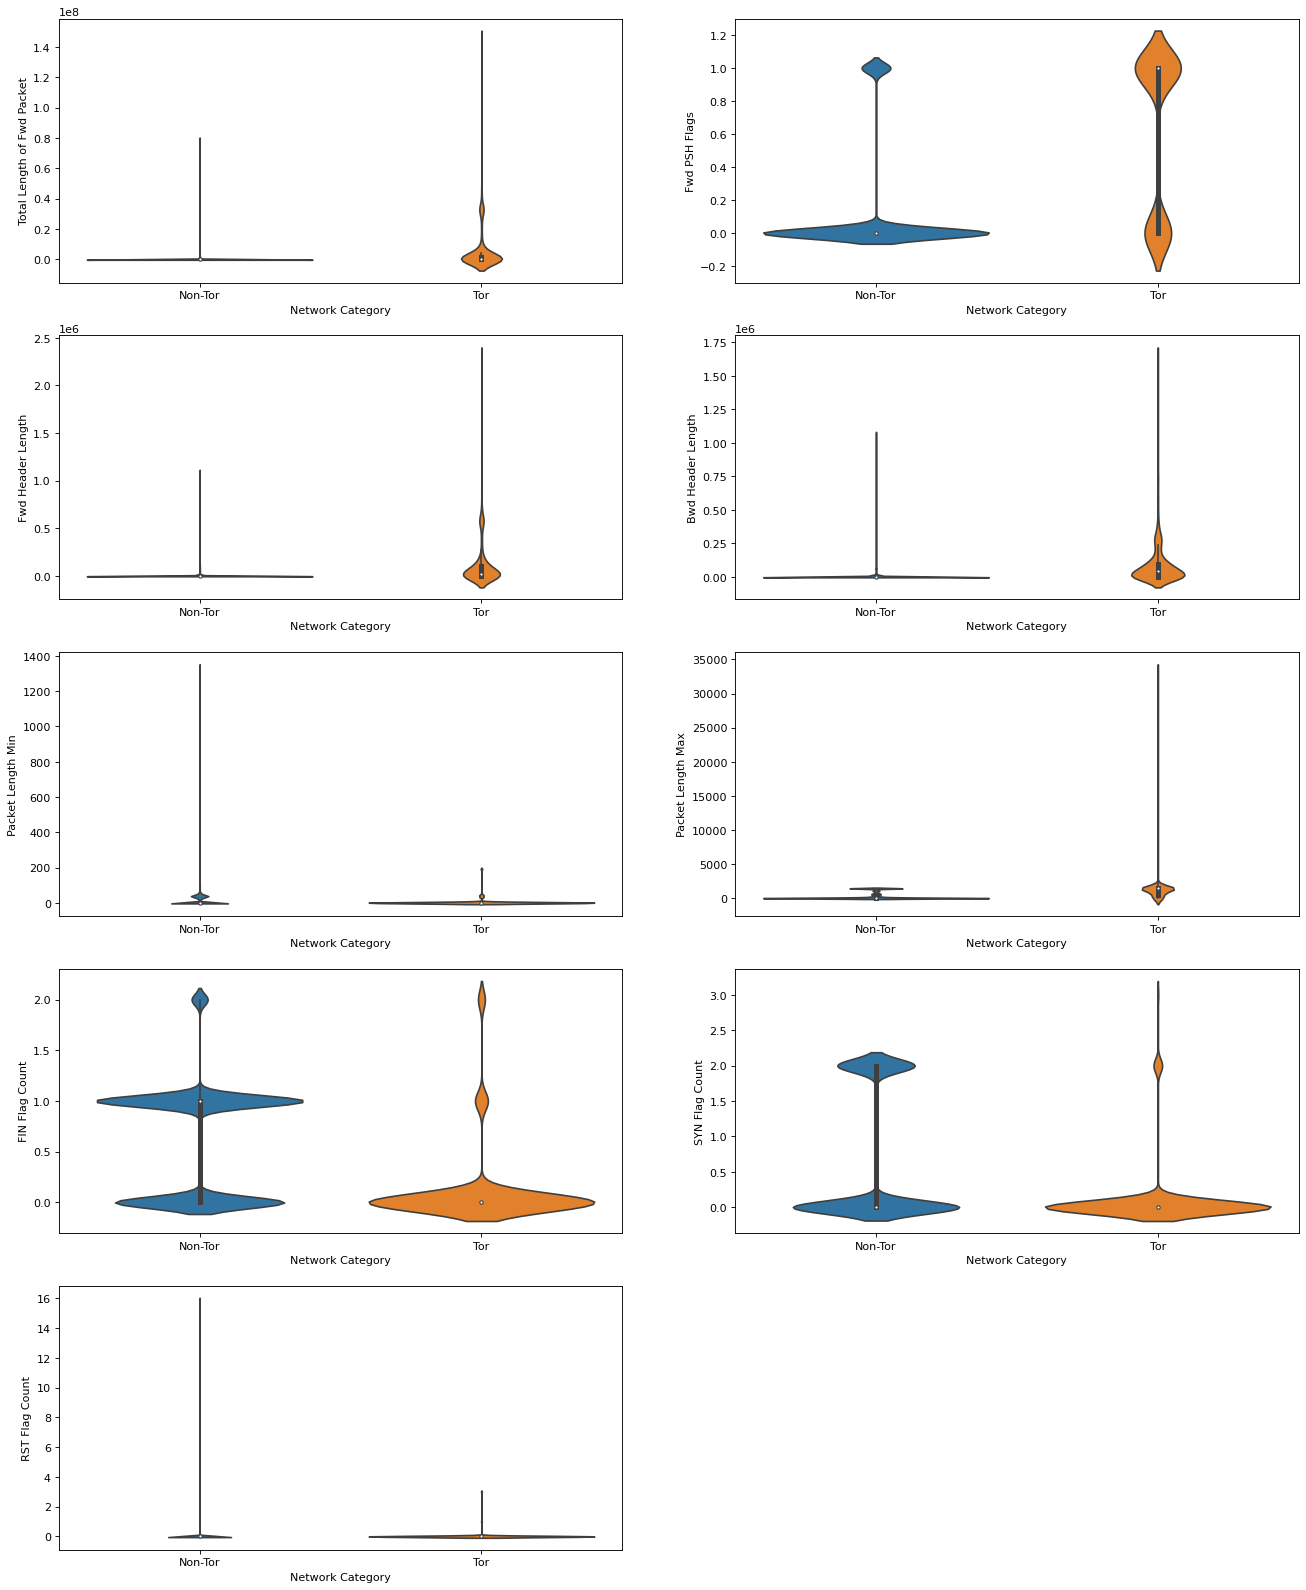

In [20]:
plt.figure(figsize=(20, 30), dpi=80)
nr = 1
for atr in df.columns[:-2]:
    plt.subplot(6, 2, nr)
    nr += 1
    sns.violinplot(data=df, x='Network Category', y=atr)

# [tu wstawić wnioski]

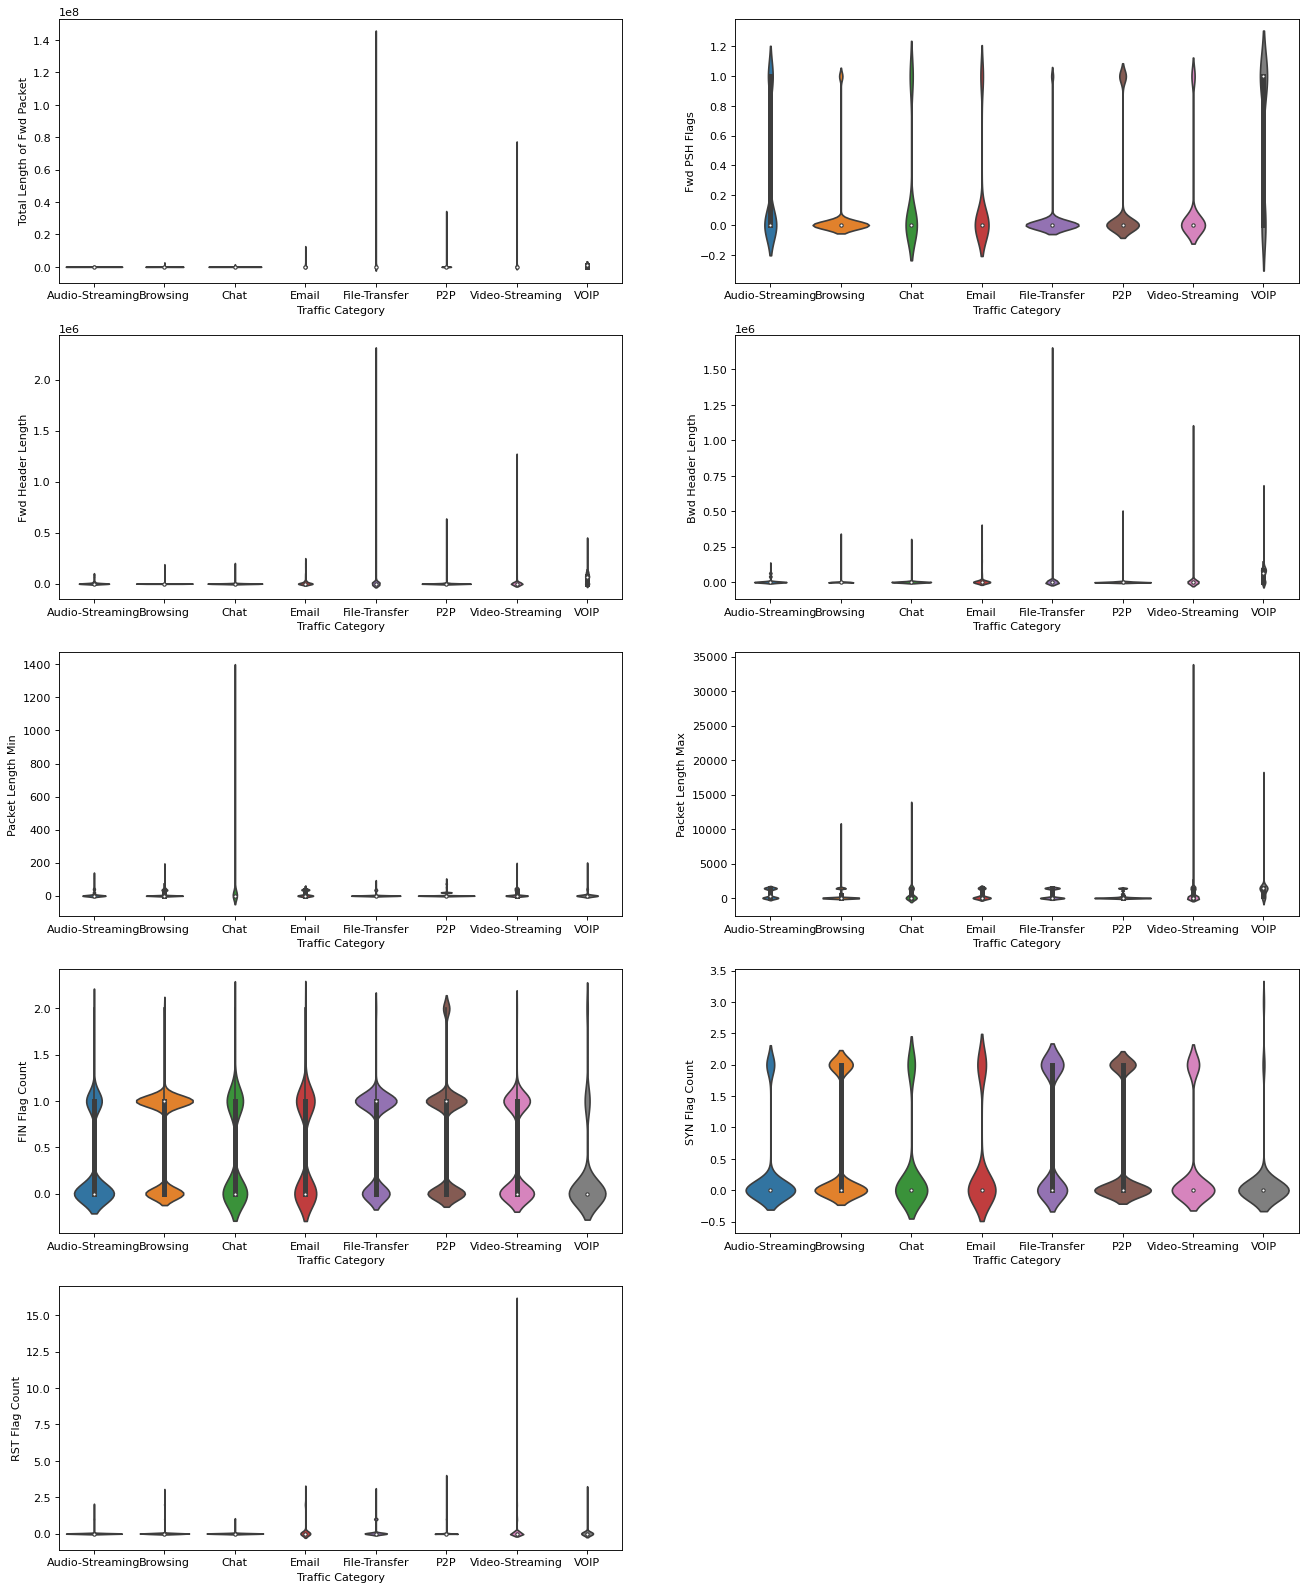

In [21]:
plt.figure(figsize=(20, 30), dpi=80)
nr = 1
for atr in df.columns[:-2]:
    plt.subplot(6, 2, nr)
    nr += 1
    sns.violinplot(data=df, x='Traffic Category', y=atr)

# [tu wstawić wnioski]

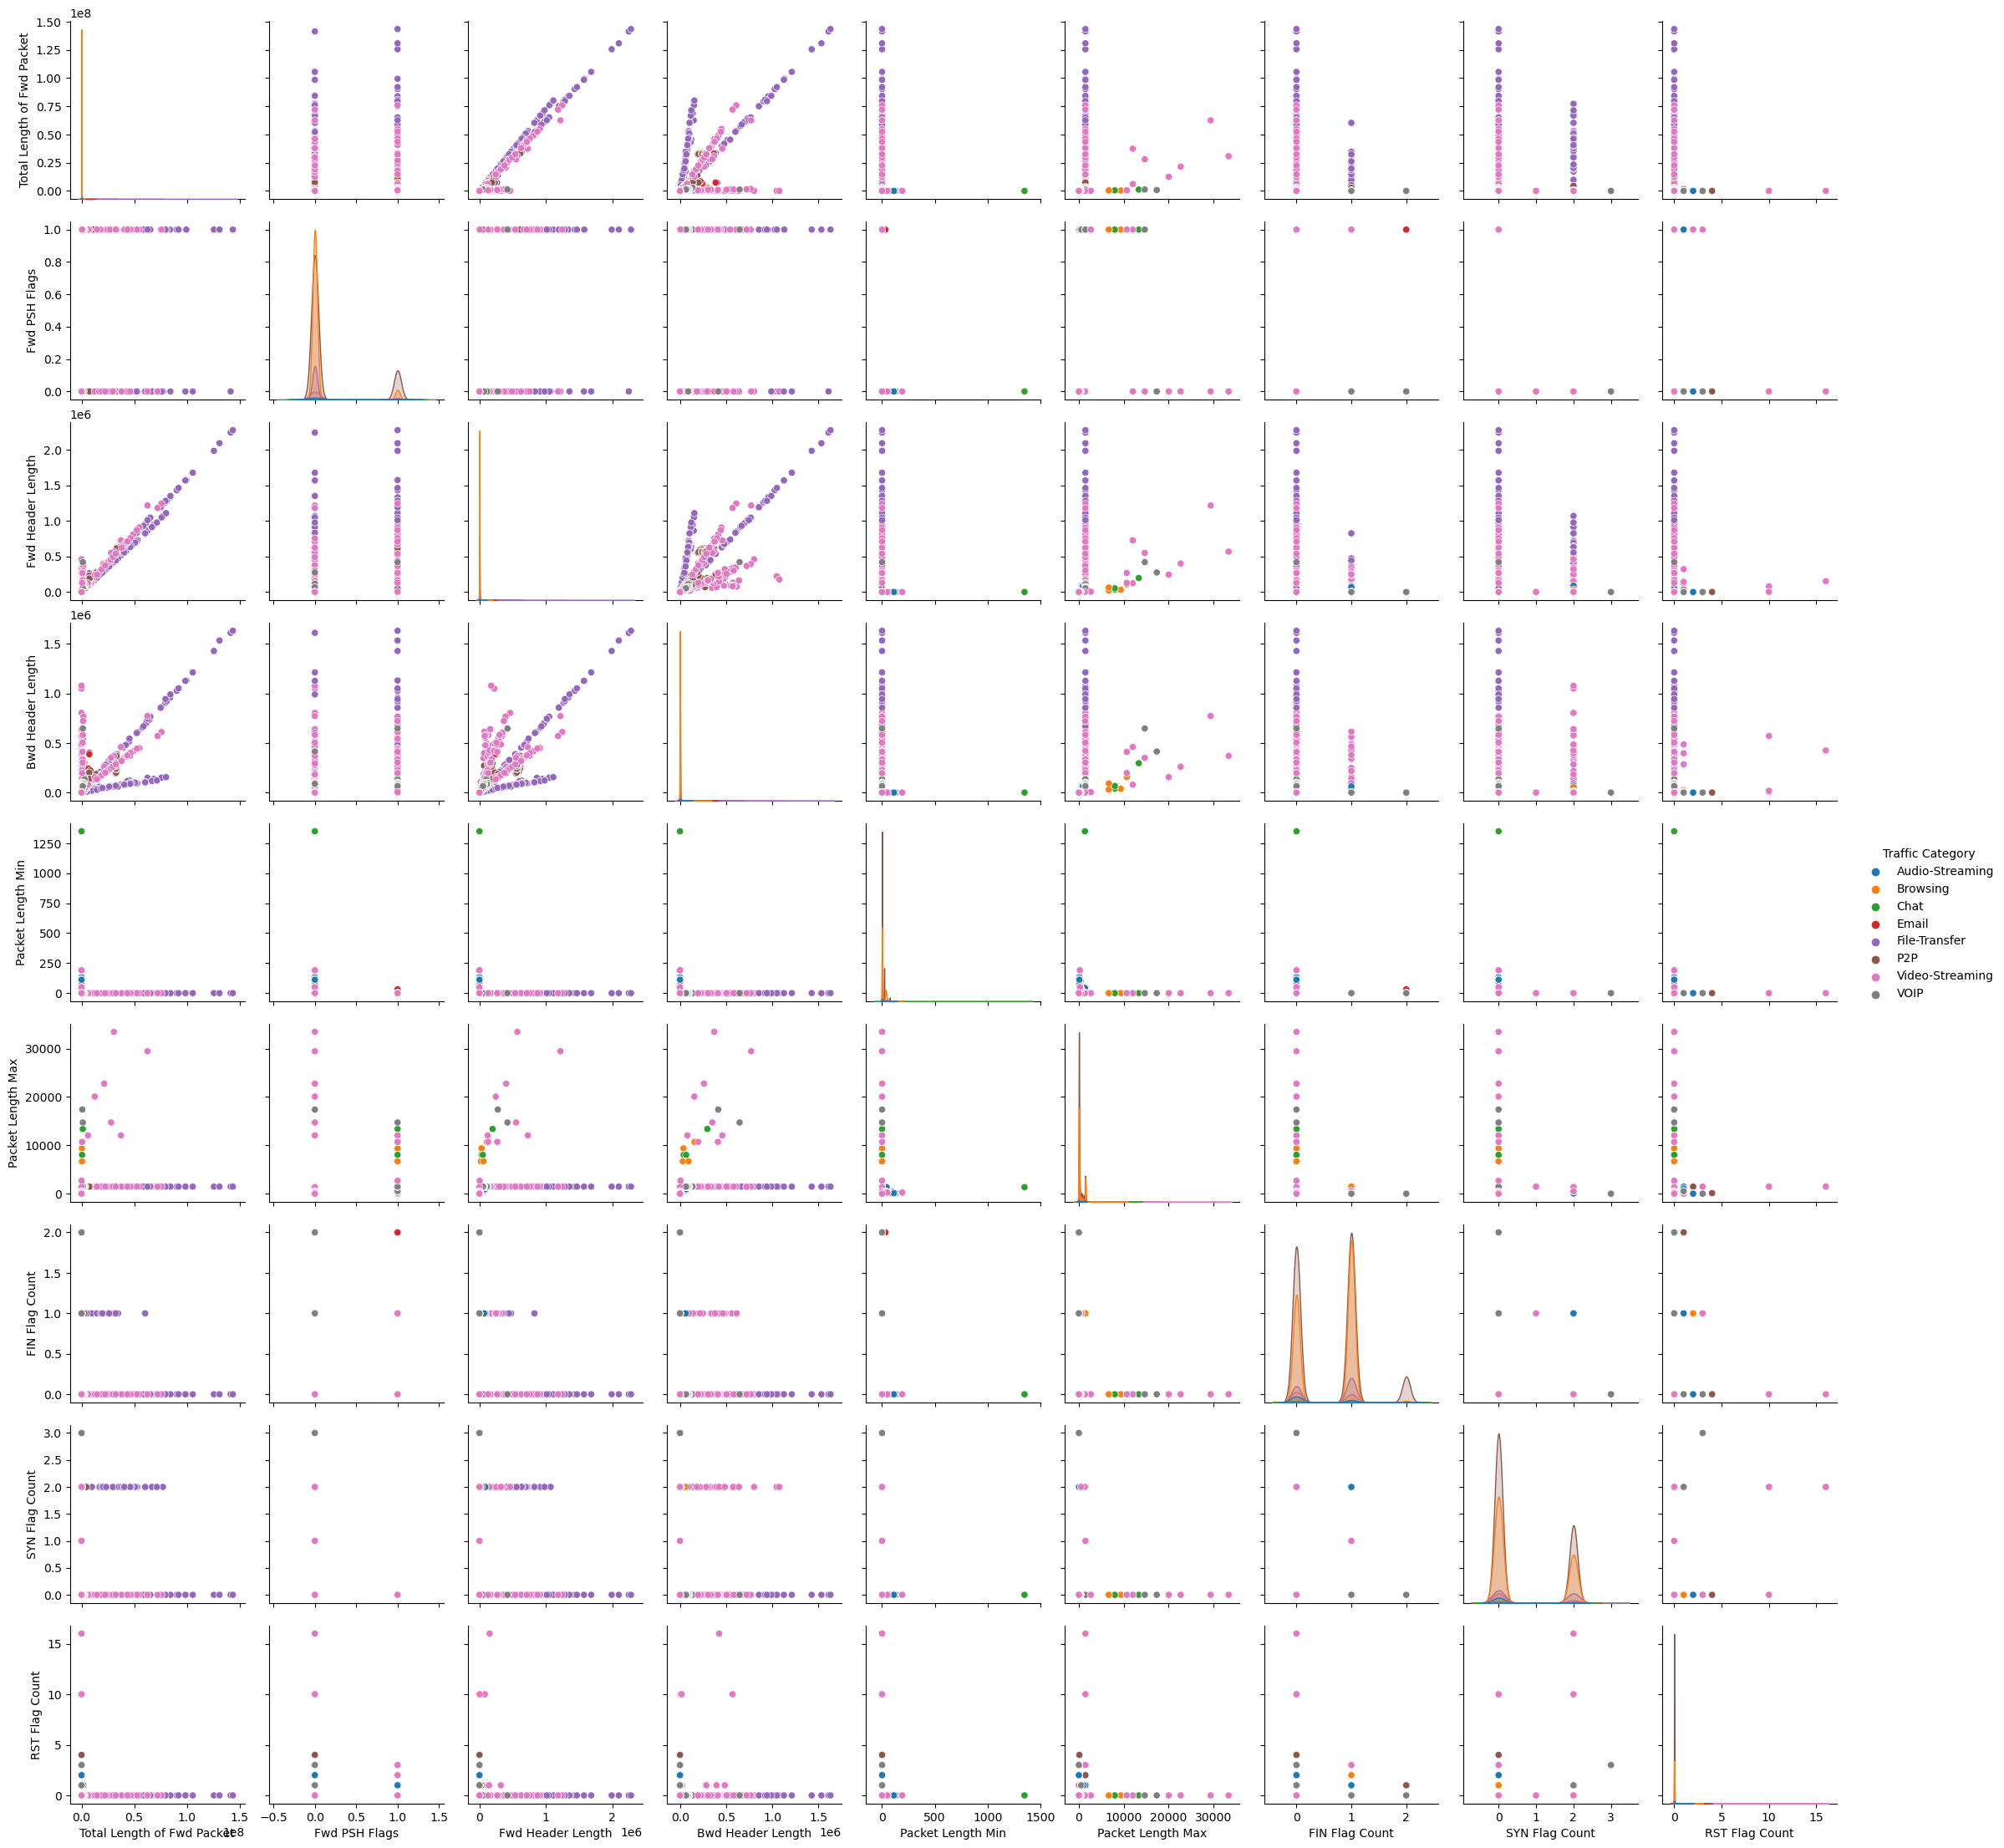

In [23]:
# NIE RUSZAĆ TEGO BLOKU, BO WYGENEROWANIE TEGO ZAJĘŁO BARDZO DUŻO CZASU I RAMU!!!
sns.pairplot(df, kind="scatter", hue="Traffic Category")
plt.show()

<AxesSubplot:>

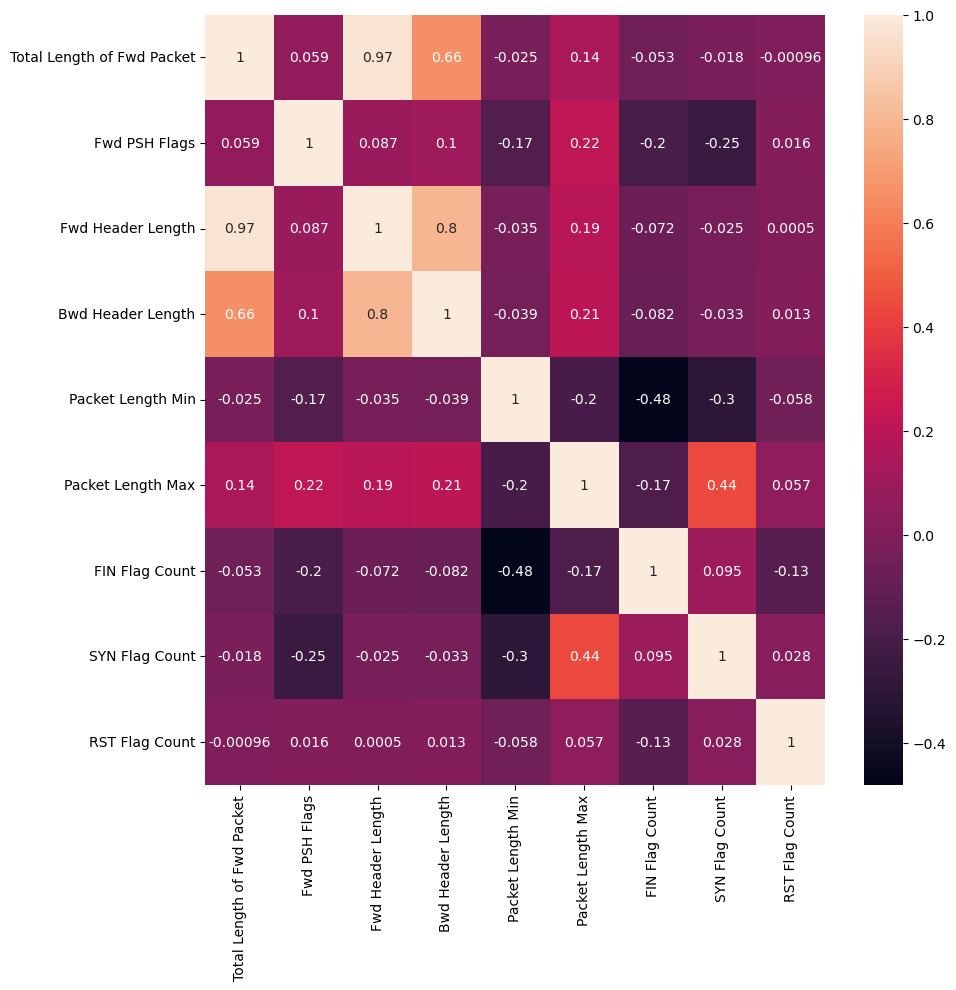

In [4]:
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(df.corr(), annot=df.corr())

Skorelowanie atrybutów 'Total Length of Fwd Packet' i 'Fwd Header Length'
współczynnik korelacji =  0.968655721686566


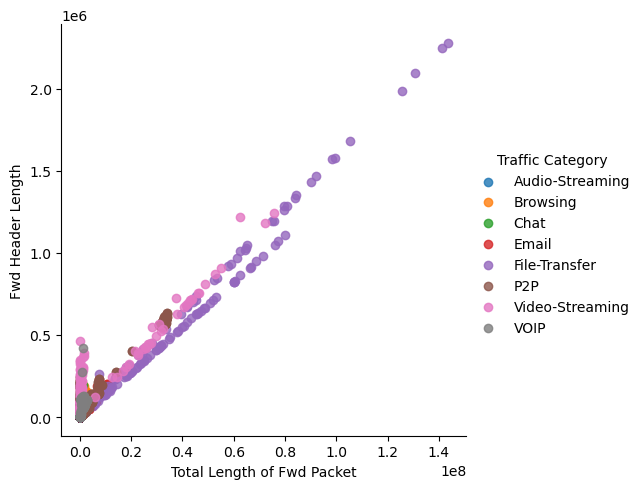

In [13]:
print("Skorelowanie atrybutów 'Total Length of Fwd Packet' i 'Fwd Header Length'")
print("współczynnik korelacji = ", df.corr().loc['Total Length of Fwd Packet']['Fwd Header Length'])
sns.lmplot(x='Total Length of Fwd Packet', y='Fwd Header Length', data=df, fit_reg=False, hue='Traffic Category', legend=True)

Skorelowanie atrybutów 'Bwd Header Length' i 'Fwd Header Length'
współczynnik korelacji =  0.7969474452147761


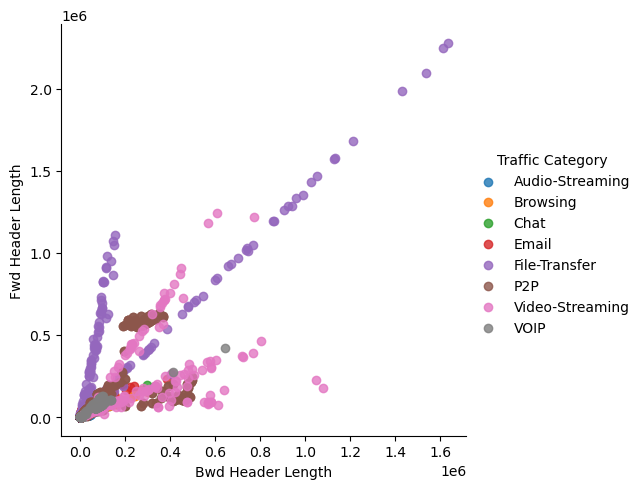

In [14]:
print("Skorelowanie atrybutów 'Bwd Header Length' i 'Fwd Header Length'")
print("współczynnik korelacji = ", df.corr().loc['Bwd Header Length']['Fwd Header Length'])
sns.lmplot(x='Bwd Header Length', y='Fwd Header Length', data=df, fit_reg=False, hue='Traffic Category', legend=True)

# [tu napisać wnioski o korelacji]

# [tu napisać wnioski o wyborze atrybutów do klasyfikacji]

## Klasyfikacja binarna Tor vs Non-Tor

In [4]:
def podziel(df, proporcja):
    # dzieli macierz (ramkę) danych na zbiór uczacy i testowy
    # df - ramka danych; proporcja - proporcja podzialu (0-1)
    # zwraca słownik z kluczami:
    # opis_ucz/opis_test - macierz atrybutów opisujących zbioru uczącego/testowego
    # dec_ucz/dec_test - wektor wartosci atrybutu decyzyjnego zbioru uczącego/testowego
    # uwaga: atrybut decyzyjny jest zawsze na końcu (ostatnia kolumna ramki)
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

In [32]:
def weryfikuj_bin(model, dane, atryb, verbose=False):
    # wyswietla wynik weryfikacji klasyfikatora w postaci macierzy pomyłek
    # dla zbioru uczącego i testowego
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atryb - lista atrybutów uwzględnianych w weryfikacji
    model.fit(dane["opis_ucz"].iloc[:, atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:, atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:, atryb])
    
    mp_ucz = confusion_matrix(dane["dec_ucz"], wynik_ucz)
    tn = mp_ucz[0][0]
    fn = mp_ucz[1][0]
    tp = mp_ucz[1][1]
    fp = mp_ucz[0][1]
    recall = tp / (tp + fn)
    missrate = 1 - recall
    specificity = tn / (tn + fp)
    fallout = 1 - specificity
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    miary_ucz = [recall, missrate, specificity, fallout, precision, accuracy]
    
    if(verbose == True):
        print("ZBIÓR UCZĄCY")
        print("\tczułość (recall) = ", recall)
        print("\tmiss rate = ", missrate)
        print("\tswoistość (specificity) = ", specificity)
        print("\tfall-out = ", fallout)
        print("\tprecyzja (precision) = ", precision)
        print("\tdokładność (accuracy) = ", accuracy)
        print("macierz pomyłek - zbiór uczący")
        print(mp_ucz)
    
    mp_test = confusion_matrix(dane["dec_test"], wynik_test)
    tn = mp_test[0][0]
    fn = mp_test[1][0]
    tp = mp_test[1][1]
    fp = mp_test[0][1]
    recall = tp / (tp + fn)
    missrate = 1 - recall
    specificity = tn / (tn + fp)
    fallout = 1 - specificity
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    miary_test = [recall, missrate, specificity, fallout, precision, accuracy]
    
    if(verbose == True):
        print("\nZBIÓR TESTOWY")
        print("\tczułość (recall) = ", recall)
        print("\tmiss rate = ", missrate)
        print("\tswoistość (specificity) = ", specificity)
        print("\tfall-out = ", fallout)
        print("\tprecyzja (precision) = ", precision)
        print("\tdokładność (accuracy) = ", accuracy)
        print("macierz pomyłek - zbiór testowy")
        print(mp_test)
    
    return mp_ucz, mp_test, miary_ucz, miary_test

In [99]:
def wyswietl_mp(mp, labels):
    disp = ConfusionMatrixDisplay(mp, display_labels=labels).plot()
    fig = disp.figure_
    fig.set_figwidth(len(labels) / 1.5)
    fig.set_figheight(len(labels) / 1.5)
    ax = disp.ax_
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.show()

Zostanie przeprowadzona klasyfikacja binarna zbioru na 2 klasy (Tor lub Non-Tor) według atrybutu decyzyjnego `Network Category`. Atrybut decyzyjny `Traffic Category` nie zostanie w niej uwzględniony. Do klasyfikacji zostaną użyte 2 klasyfikatory. Zbiór danych zostanie podzielony na uczący (70% zbioru) i testowy (30% zbioru).

In [57]:
df_bin = df.drop(columns=['Traffic Category'])
df_bin.head()

,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count,Network Category
0,0,0,20,20,0,0,2,0,0,Non-Tor
1,0,0,20,20,0,0,2,0,0,Non-Tor
2,0,0,20,20,0,0,2,0,0,Non-Tor
3,0,0,20,20,0,0,2,0,0,Non-Tor
4,64530,1,11820,8000,0,498,1,0,0,Non-Tor


In [113]:
atr = [0, 3, 4, 5, 7, 8]
print('Atrybuty brane pod uwagę przy klasyfikacji: ')
df_bin.iloc[:, atr].info()

Atrybuty brane pod uwagę przy klasyfikacji: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Total Length of Fwd Packet  94748 non-null  int64
 1   Bwd Header Length           94748 non-null  int64
 2   Packet Length Min           94748 non-null  int64
 3   Packet Length Max           94748 non-null  int64
 4   SYN Flag Count              94748 non-null  int64
 5   RST Flag Count              94748 non-null  int64
dtypes: int64(6)
memory usage: 7.1 MB


In [58]:
data_bin = podziel(df_bin, 0.3)
print('Liczba obiektów zbioru uczącego: ', len(data_bin["opis_ucz"]))
print('Liczba obiektów zbioru testowego: ', len(data_bin["opis_test"]))

Liczba obiektów zbioru uczącego:  66323
Liczba obiektów zbioru testowego:  28425


Aby wybrać najlepsze 2 klasyfikatory, zostaną przeanalizowane i porównane następujące typy klasyfikatorów:
* **klasyfikator k-NN** (najbliższych sąsiadów) dla róznych wartości k
* **klasyfikator najbliższego centroidu**
* **naiwny klasyfikator Gaussa**
* **drzewo decyzyjne** dla różnych głębokości drzewa

Przy ocenie klasyfikatora zostaną użyte następujące miary klasyfikacji zbioru testowego:
* **czułość (recall)** - obiekty poprawnie sklasyfikowane jako `Tor` / wszystkie obiekty klasy `Tor` w zbiorze
* **miss rate** - ułamek obiektów klasy `Tor` sklasyfikowanych niepoprawnie jako `Non-Tor` (niewykrycie zagrożenia)
* **swoistość (specificity)** - obiekty poprawnie sklasyfikowane jako `Non-Tor` / wszystkie obiekty klasy `Non-Tor` w zbiorze
* **fall-out** - ułamek obiektów klasy `Non-Tor` sklasyfikowanych niepoprawnie jako `Tor` (fałszywy alarm)
* **precyzja (precision)** - obiekty poprawnie sklasyfikowane jako `Tor` / wszystkie obiekty sklasyfikowane jako `Tor`
* **dokładność (accuracy)** - wszystkie poprawnie sklasyfikowane obiekty / wszystkie obiekty w zbiorze

**Czułość**, **swoistość**, **precyzja** oraz **dokładność** powinny być jak najwyższe, natomiast **miss rate** i **fall-out** - jak najniższe. Jednak ze względu na specyfikę zbioru (niezbalansowane klasy), największa uwaga będzie zwrócona na zmaksymalizowanie **czułości** (i pośrednio zminimalizowanie **miss rate**).

Na początku zostanie wybrana optymalna liczba sąsiadów dla **klasyfikatora k-NN** oraz optymalna głębokość drzewa dla **drzewa decyzyjnego**. Następnie wszystkie 4 klasyfikatory zostaną porównane oraz wybrane 2 najlepsze z nich.

### Wybór optymalnej liczby sąsiadów dla klasyfikatora k-NN

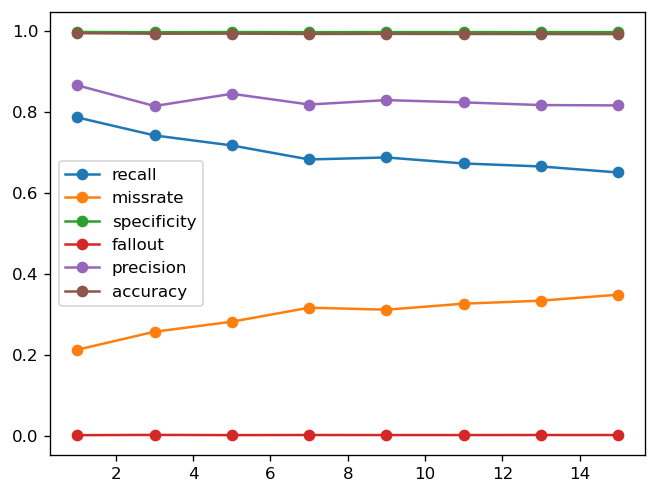

In [59]:
# ignorowanie ostrzeżeń typu 'Future Waring' dla czytelności
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    k_values = [1, 3, 5, 7, 9, 11, 13, 15]
    miary = np.zeros((len(k_values), 6))
    i = 0
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        _, _, _, miary_test = weryfikuj_bin(model, data_bin, atr)
        miary[i] = miary_test
        i += 1
    
    plt.figure(dpi=120)
    labels = ['recall', 'missrate', 'specificity', 'fallout', 'precision', 'accuracy']
    for i in range(len(miary_test)):
        plt.plot(k_values, miary[:, i], 'o-', label=labels[i])
    plt.legend()
    plt.show()

Analiza wartości współczynników dla **klasyfikatora k-NN** dla różnych wartości k:
* wraz ze wzrostem wartości k, **czułość** spada (**miss rate** rośnie)
* wartość **precyzji** oscyluje około 0.83
* wartości pozostałych współczynników pozostają na takim samym poziomie dla wszystkich wartości k

Najlepsze wyniki daje **klasyfikator 1-NN**. Zostanie on uwzględniony w porównaniu wszystkich klasyfikatorów.

### Wybór optymalnej głębokości drzewa decyzyjnego

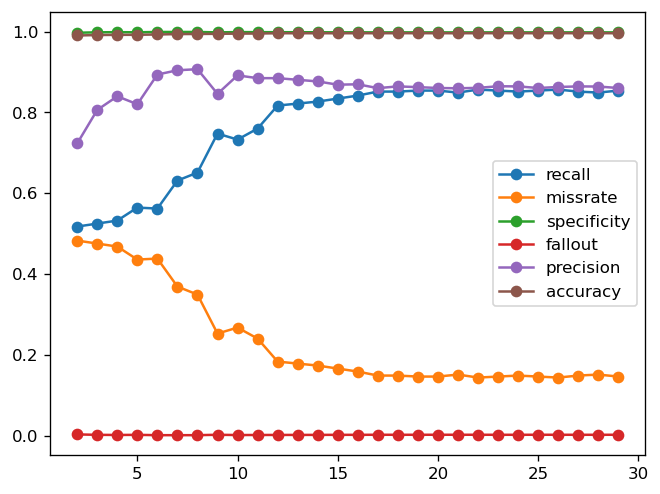

In [115]:
depth_values = range(2, 30)
miary = np.zeros((len(depth_values), 6))
i = 0
for depth in depth_values:
    model = tree.DecisionTreeClassifier(max_depth=depth)
    _, _, _, miary_test = weryfikuj_bin(model, data_bin, atr)
    miary[i] = miary_test
    i += 1

plt.figure(dpi=120)
labels = ['recall', 'missrate', 'specificity', 'fallout', 'precision', 'accuracy']
for i in range(len(miary_test)):
    plt.plot(depth_values, miary[:, i], 'o-', label=labels[i])
plt.legend()
plt.show()

Analiza wartości współczynników dla **drzewa decyzyjnego** dla różnych głębokości:
* dla głębokości pomiędzy 6 a 12 wartość **czułości** gwałtowanie rośnie (wartość **miss rate** gwałtownie spada)
* dla głębokości pomiędzy 12 a 15 wzrost **czułości** (i spadek **miss rate**) się stabilizują
* wartość **precyzji** stabilizuje się między głębokościami 11 a 17
* wartości pozostałych współczynników pozostają na takim samym poziomie dla wszystkich głębokości drzewa

Do dalszej analizy zostało wybrane **drzewo decyzyjne o głębokości = 15**.

### Porównanie klasyfikatorów i wybór dwóch najlepszych

In [96]:
# ignorowanie ostrzeżeń typu 'Future Waring' dla czytelności
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    models = [KNeighborsClassifier(n_neighbors=1), tree.DecisionTreeClassifier(max_depth=15), NearestCentroid(), GaussianNB()]
    miary = np.zeros((len(models), 6))
    model_nr = 0
    for model in models:
        _, _, _, miary_test = weryfikuj_bin(model, data_bin, atr)
        miary[model_nr] = miary_test
        model_nr += 1

measures = ['recall', 'missrate', 'specificity', 'fallout', 'precision', 'accuracy']
classifiers = ['1-NN', 'DecisionTree', 'NearestCentroid', 'GaussianNB']
miary_df = pd.DataFrame(miary, columns=measures, index=classifiers)
miary_df

,recall,missrate,specificity,fallout,precision,accuracy
1-NN,0.79,0.21,1.00,0.00,0.87,1.00
DecisionTree,0.84,0.16,1.00,0.00,0.87,1.00
NearestCentroid,0.21,0.79,1.00,0.00,0.72,0.99
GaussianNB,0.35,0.65,1.00,0.00,0.59,0.99


<AxesSubplot:>

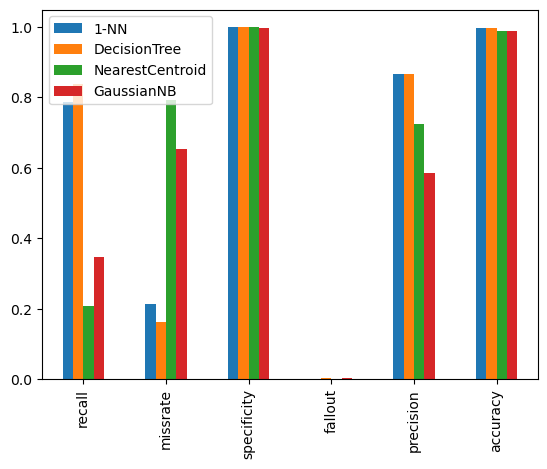

In [97]:
miary_df.T.plot.bar()

Analiza wyników klasyfikacji:
* pod względem **swoistości**, **fall-out'u** i **dokładności** wszystkie klasyfikatory uzyskują dobre wyniki
* najlepsze wartości współczynnika **precyzji** uzyskuje **drzewo decyzyjne** oraz **klasyfikator 1-NN**
* pod względem **czułości** i **miss rate'u** znacząco lepsze wyniki od pozostałych klasyfikatorów uzyskuje **drzewo decyzyjne** i **klasyfikator 1-NN**

Najlepszymi dwoma klasyfikatorami do klasyfikacji binarnej `Tor` vs `Non-Tor` są: **drzewo decyzyjne dla głębokości = 15** oraz **klasyfikator 1-NN**.

### Klasyfikator 1-NN

Macierz pomyłek - zbiór uczący


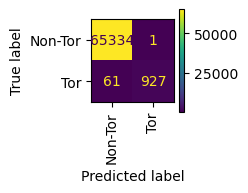

recall  =  0.9382591093117408
missrate  =  0.061740890688259165
specificity  =  0.9999846942680034
fallout  =  1.5305731996595462e-05
precision  =  0.9989224137931034
accuracy  =  0.9990651810080967

Macierz pomyłek - zbiór testowy


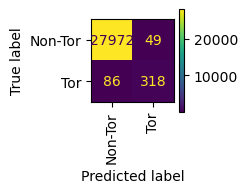

recall  =  0.7871287128712872
missrate  =  0.21287128712871284
specificity  =  0.9982513115163627
fallout  =  0.0017486884836372951
precision  =  0.8664850136239782
accuracy  =  0.9952506596306069


In [92]:
# ignorowanie ostrzeżeń typu 'Future Waring' dla czytelności
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    model = KNeighborsClassifier(n_neighbors=1)
    mp_ucz, mp_test, miary_ucz, miary_test = weryfikuj_bin(model, data_bin, atr)
    labels = list(df_bin.loc[:, 'Network Category'].unique())
    measures = ['recall', 'missrate', 'specificity', 'fallout', 'precision', 'accuracy']
    print("Macierz pomyłek - zbiór uczący")
    wyswietl_mp(mp_ucz, labels)
    for i in range(len(miary_ucz)):
        print(measures[i], " = ", miary_ucz[i])
    print("\nMacierz pomyłek - zbiór testowy")
    wyswietl_mp(mp_test, labels)
    for i in range(len(miary_test)):
        print(measures[i], " = ", miary_test[i])

### Drzewo decyzyjne o głębokości = 15

Macierz pomyłek - zbiór uczący


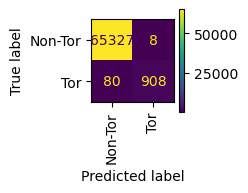

recall  =  0.9190283400809717
missrate  =  0.08097165991902833
specificity  =  0.9998775541440269
fallout  =  0.00012244585597309676
precision  =  0.9912663755458515
accuracy  =  0.9986731601405244

Macierz pomyłek - zbiór testowy


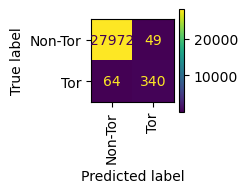

recall  =  0.8415841584158416
missrate  =  0.15841584158415845
specificity  =  0.9982513115163627
fallout  =  0.0017486884836372951
precision  =  0.8740359897172236
accuracy  =  0.9960246262093227


In [116]:
model = tree.DecisionTreeClassifier(max_depth=15)
mp_ucz, mp_test, miary_ucz, miary_test = weryfikuj_bin(model, data_bin, atr)
labels = list(df_bin.loc[:, 'Network Category'].unique())
measures = ['recall', 'missrate', 'specificity', 'fallout', 'precision', 'accuracy']
print("Macierz pomyłek - zbiór uczący")
wyswietl_mp(mp_ucz, labels)
for i in range(len(miary_ucz)):
    print(measures[i], " = ", miary_ucz[i])
print("\nMacierz pomyłek - zbiór testowy")
wyswietl_mp(mp_test, labels)
for i in range(len(miary_test)):
    print(measures[i], " = ", miary_test[i])

**Drzewo decyzyjne o głębokości = 15** uzyskuje nieco lepsze wyniki dla zbioru testowego od **klasyfikatora 1-NN** oraz działa znacznie szybciej.

## Klasyfikacja według rodzaju ruchu sieciowego

In [100]:
def weryfikuj(model, dane, atryb, verbose=False):
    # wyswietla wynik weryfikacji klasyfikatora w postaci macierzy pomyłek
    # dla zbioru uczącego i testowego
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atryb - lista atrybutów uwzględnianych w weryfikacji
    model.fit(dane["opis_ucz"].iloc[:, atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:, atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:, atryb])
    
    mp_ucz = confusion_matrix(dane["dec_ucz"], wynik_ucz)
    accuracy_ucz = np.sum(np.diag(mp_ucz)) / np.sum(mp_ucz)
    if(verbose == True):
        print("macierz pomyłek - zbiór uczący, dokładność:", accuracy_ucz)
        print(mp_ucz)
    
    mp_test = confusion_matrix(dane["dec_test"], wynik_test)
    accuracy_test = np.sum(np.diag(mp_test)) / np.sum(mp_test)
    if(verbose == True):
        print("macierz pomyłek - zbiór testowy, dokładność:", accuracy_test)
        print(mp_test)
    
    return mp_ucz, mp_test, accuracy_ucz, accuracy_test

Zostanie przeprowadzona klasyfikacja zbioru na 16 klas według złączeniu atrybutu decyzyjnego `Network Category` oraz `Traffic Category`. Do klasyfikacji zostaną użyte te same 2 klasyfikatory, jak przy klasyfikacji binarnej `Tor` vs `Non-Tor`. Zbiór danych zostanie podzielony na uczący (70% zbioru) i testowy (30% zbioru).

In [101]:
df_traffic = df.copy()
df_traffic['Category'] = df_traffic['Network Category'] + ' ' + df_traffic['Traffic Category']
df_traffic.drop(columns=['Network Category', 'Traffic Category'], inplace=True)
df_traffic.head()

,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count,Category
0,0,0,20,20,0,0,2,0,0,Non-Tor Audio-Streaming
1,0,0,20,20,0,0,2,0,0,Non-Tor Audio-Streaming
2,0,0,20,20,0,0,2,0,0,Non-Tor Audio-Streaming
3,0,0,20,20,0,0,2,0,0,Non-Tor Audio-Streaming
4,64530,1,11820,8000,0,498,1,0,0,Non-Tor Audio-Streaming


In [102]:
print("Liczba kategorii ruchu = ", len(df_traffic.loc[:, 'Category'].unique()))

Liczba kategorii ruchu =  15


Liczba kategorii jest równa 15 zamiast wspomnianych wcześniej 16, ponieważ w zbiorze nie występują obiekty należące do klasy `Non-Tor VOIP`.

In [103]:
print("Liczba obiektów w danej klasie:")
for k in list(df_traffic.loc[:, 'Category'].unique()):
    print(k, " = ", df_traffic[df_traffic['Category'] == k].shape[0])

Liczba obiektów w danej klasie:
Non-Tor Audio-Streaming  =  1484
Non-Tor Browsing  =  32545
Non-Tor Chat  =  413
Non-Tor Email  =  492
Non-Tor File-Transfer  =  6740
Non-Tor P2P  =  48300
Non-Tor Video-Streaming  =  3382
Tor Audio-Streaming  =  224
Tor Browsing  =  263
Tor Chat  =  65
Tor File-Transfer  =  107
Tor Email  =  13
Tor P2P  =  220
Tor Video-Streaming  =  202
Tor VOIP  =  298


In [114]:
atr = [0, 3, 4, 5, 7, 8]
print('Atrybuty brane pod uwagę przy klasyfikacji: ')
df_traffic.iloc[:, atr].info()

Atrybuty brane pod uwagę przy klasyfikacji: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Total Length of Fwd Packet  94748 non-null  int64
 1   Bwd Header Length           94748 non-null  int64
 2   Packet Length Min           94748 non-null  int64
 3   Packet Length Max           94748 non-null  int64
 4   SYN Flag Count              94748 non-null  int64
 5   RST Flag Count              94748 non-null  int64
dtypes: int64(6)
memory usage: 7.1 MB


In [104]:
data_traffic = podziel(df_traffic, 0.3)
print('Liczba obiektów zbioru uczącego: ', len(data_traffic["opis_ucz"]))
print('Liczba obiektów zbioru testowego: ', len(data_traffic["opis_test"]))

Liczba obiektów zbioru uczącego:  66323
Liczba obiektów zbioru testowego:  28425


### Klasyfikator 1-NN

Macierz pomyłek - zbiór uczący, dokładność =  0.7940835004447929


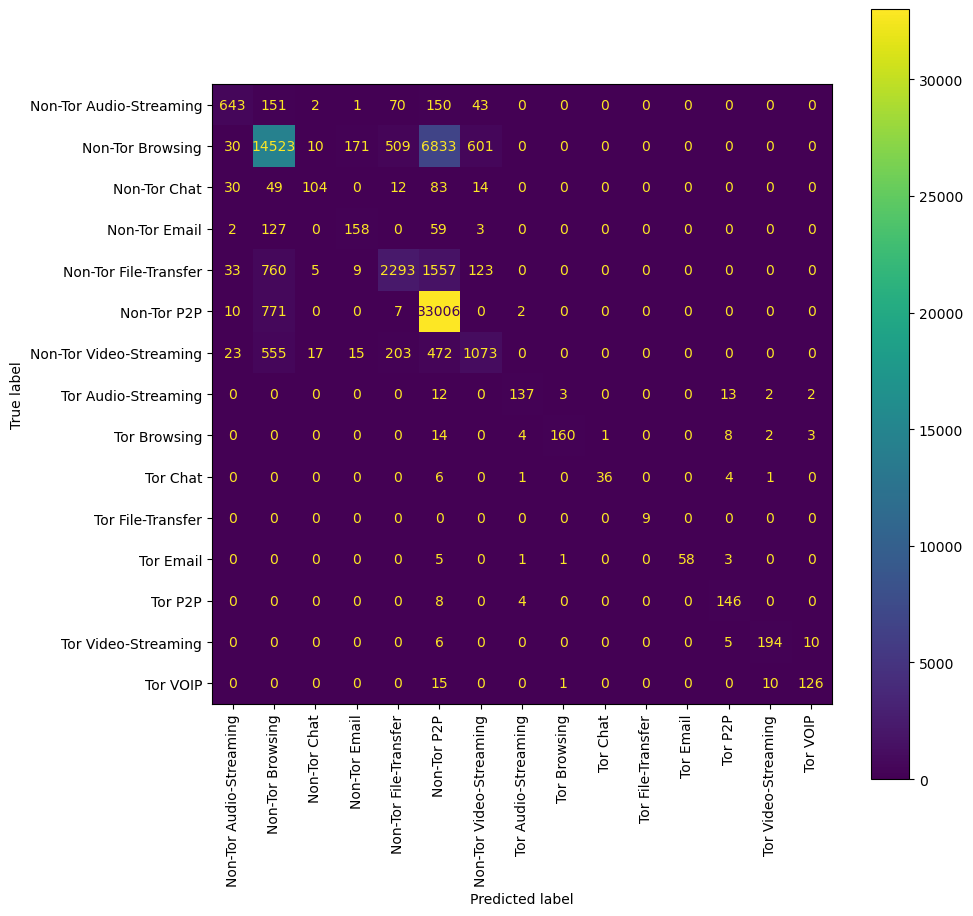

Macierz pomyłek - zbiór testowy, dokładność =  0.7445558487247141


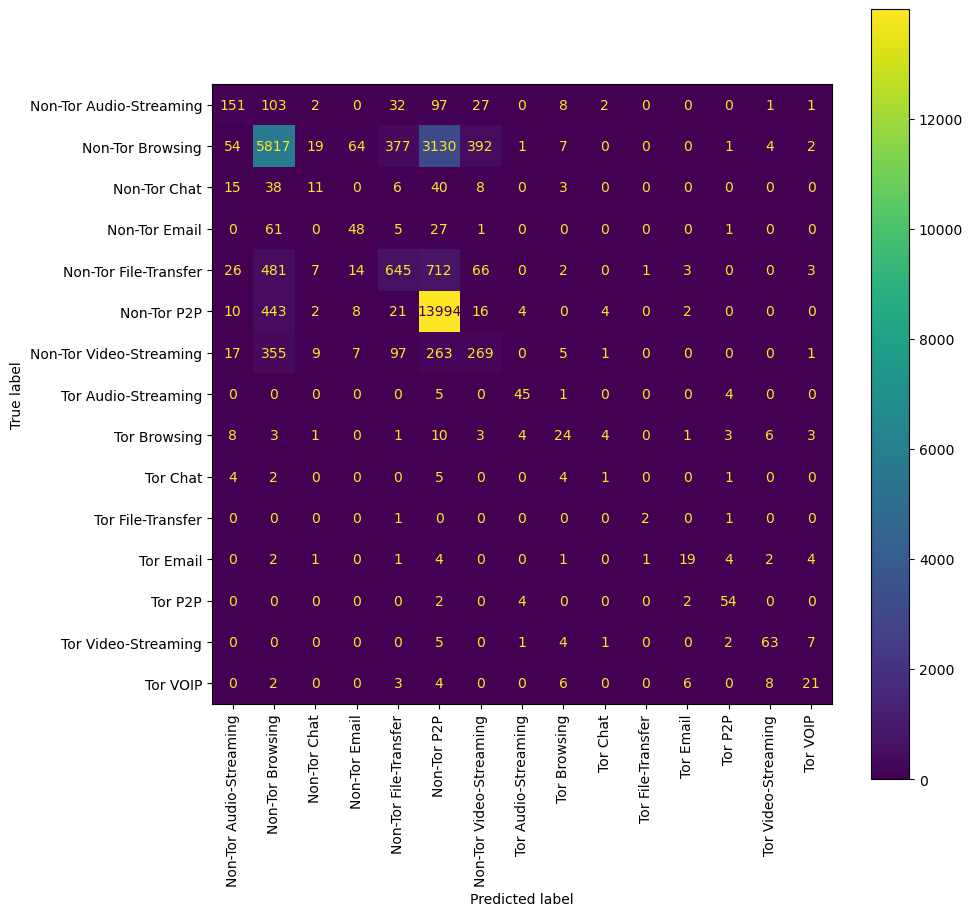

In [105]:
# ignorowanie ostrzeżeń typu 'Future Waring' dla czytelności
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    model = KNeighborsClassifier(n_neighbors=1)
    mp_ucz, mp_test, accuracy_ucz, accuracy_test = weryfikuj(model, data_traffic, atr)
    labels = list(df_traffic.loc[:, 'Category'].unique())
    print("Macierz pomyłek - zbiór uczący, dokładność = ", accuracy_ucz)
    wyswietl_mp(mp_ucz, labels)
    print("Macierz pomyłek - zbiór testowy, dokładność = ", accuracy_test)
    wyswietl_mp(mp_test, labels)

Analiza wyników klasyfikacji obiektów w zbiorze testowym za pomocą **klasyfikatora 1-NN**:
* najwięcej obiektów klasy `Non-Tor Audio-Streaming` zostało sklasyfikowane poprawnie, jednak spora część została sklasyfikowana błędnie jako `Non-Tor Browsing` lub `Non-Tor P2P`
* większość obiektów klasy `Non-Tor Browsing` została sklasyfikowana poprawnie, jednak spora część została sklasyfikowana błędnie jako `Non-Tor P2P`
* większość obiektów klasy `Non-Tor Chat` została sklasyfikowana błędnie jako `Non-Tor Browsing` lub `Non-Tor P2P`
* większość obiektów klasy `Non-Tor Email` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* spora część obiektów klasy `Non-Tor File-Transfer` została sklasyfikowana błędnie jako `Non-Tor Browsing` lub `Non-Tor P2P`
* znacząca wiekszość obiektów klasy `Non-Tor P2P` została sklasyfikowana poprawnie
* spora część obiektów klasy `Non-Tor Video-Streaming` została sklasyfikowana błędnie jako `Non-Tor Browsing` lub `Non-Tor P2P`
* większość obiektów klas `Tor Audio-Streaming`, `Tor Browsing`, `Tor Email`, `Tor P2P`, `Tor Video-Streaming`, `Tor VOIP` została sklasyfikowana poprawnie
* liczba obiektów z klas `Tor Chat` i `Tor File-Transfer` w zbiorze testowym była na tyle mała, że wyciąganie wniosków jest *daremne*

Macierz pomyłek - zbiór uczący, dokładność =  0.8219019043167528


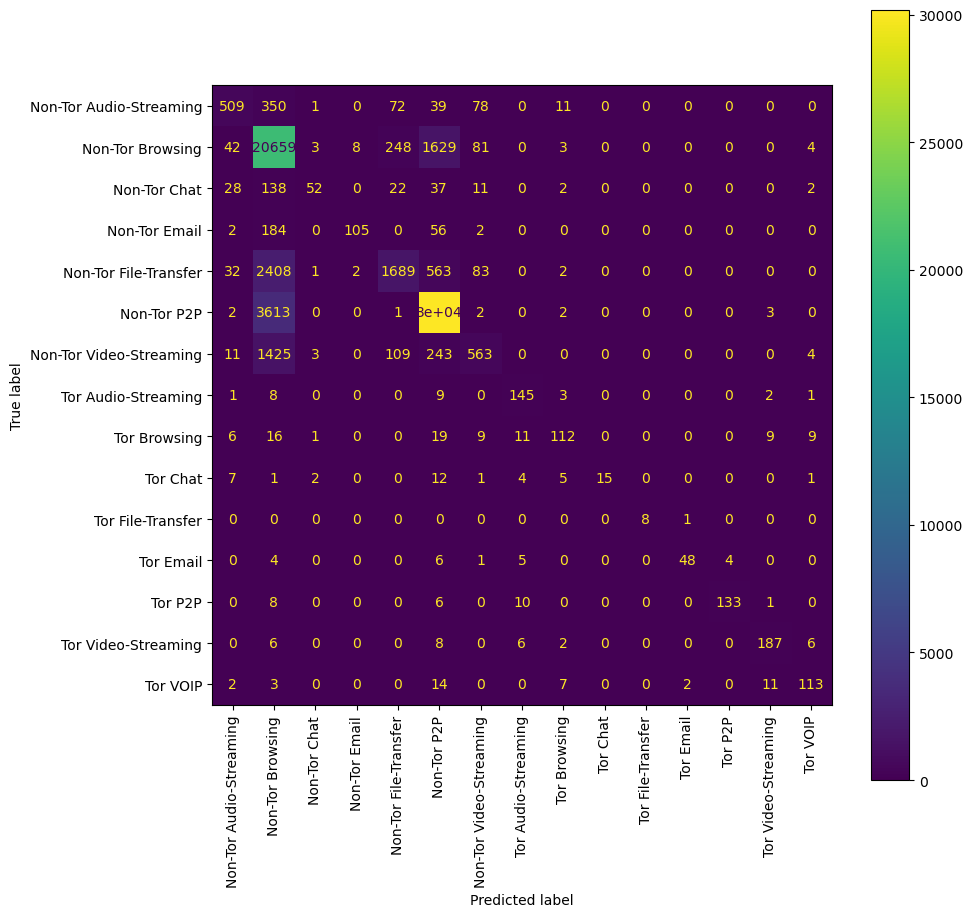

Macierz pomyłek - zbiór testowy, dokładność =  0.8150219876868954


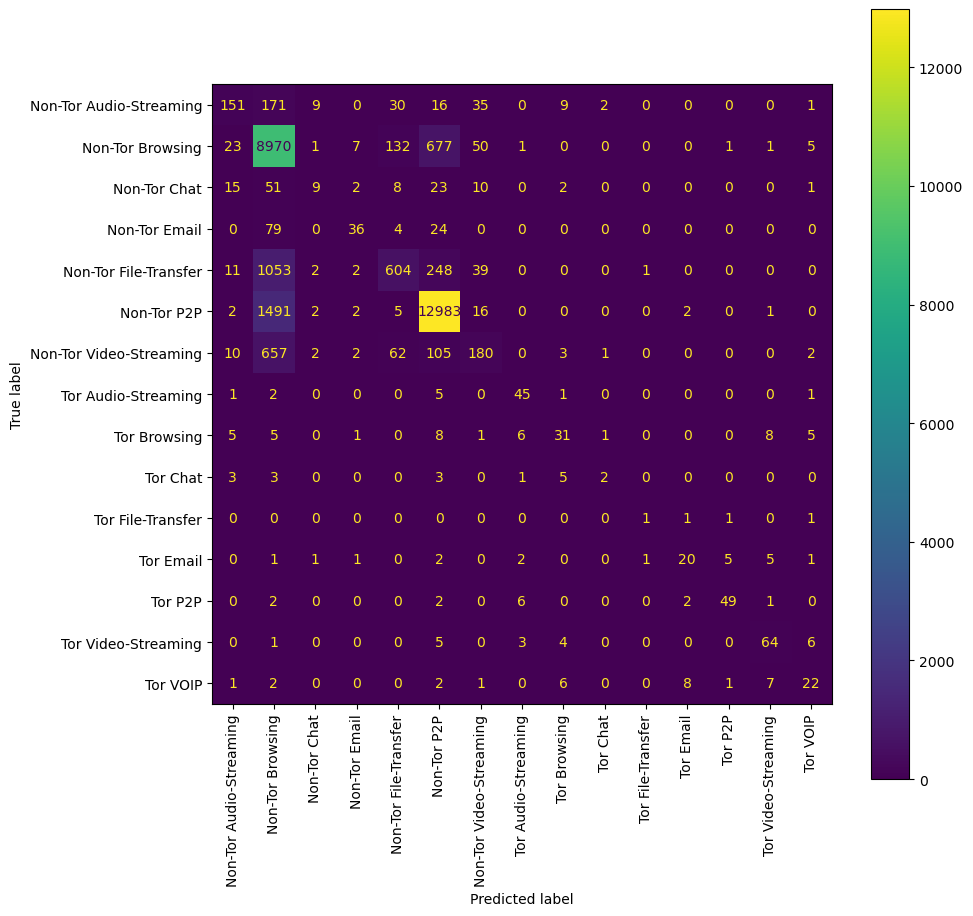

In [117]:
model = tree.DecisionTreeClassifier(max_depth=15)
mp_ucz, mp_test, accuracy_ucz, accuracy_test = weryfikuj(model, data_traffic, atr)
labels = list(df_traffic.loc[:, 'Category'].unique())
print("Macierz pomyłek - zbiór uczący, dokładność = ", accuracy_ucz)
wyswietl_mp(mp_ucz, labels)
print("Macierz pomyłek - zbiór testowy, dokładność = ", accuracy_test)
wyswietl_mp(mp_test, labels)

Analiza wyników klasyfikacji obiektów w zbiorze testowym za pomocą **drzewa decyzyjnego o głębokości = 15**:
* spora część obiektów klasy `Non-Tor Audio-Streaming` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* większość obiektów klasy `Non-Tor Browsing` została sklasyfikowana poprawnie
* większość obiektów klasy `Non-Tor Chat` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* większość obiektów klasy `Non-Tor Email` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* większość obiektów klasy `Non-Tor File-Transfer` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* znacząca wiekszość obiektów klasy `Non-Tor P2P` została sklasyfikowana poprawnie
* większość obiektów klasy `Non-Tor Video-Streaming` została sklasyfikowana błędnie jako `Non-Tor Browsing`
* większość obiektów klas `Tor Audio-Streaming`, `Tor Browsing`, `Tor Email`, `Tor P2P`, `Tor Video-Streaming`, `Tor VOIP` została sklasyfikowana poprawnie
* liczba obiektów z klas `Tor Chat` i `Tor File-Transfer` w zbiorze testowym była na tyle mała, że wyciąganie wniosków jest *daremne*

## Wnioski końcowe